In [1]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Data import

In [2]:
df = pd.read_json('../data/cleaned_class_action.json', orient='records', lines=True)

In [3]:
df.head()

,target_text,verdict,cleaned_facts
0,Knowing and/or Willful Violation of the Telep...,lose,"[knowing, willful, violation, telephone, consu..."
1,17. Defendants operate an electrical construc...,win,"[17, operate, electrical, construction, mainte..."
2,(Fair Labor Standards Act Violations) (Viola...,win,"[fair, labor, standards, act, violations, viol..."
3,"37. As set forth below, the proposed Class sa...",win,"[37, set, forth, proposed, satisfies, requirem..."
4,24. Named Plaintiffs and Class Members were em...,win,"[24, named, members, employed, call, centers, ..."


### Word embeddings

In [4]:
# Convert cleaned facts to list

corpus = df['cleaned_facts'].tolist()

In [5]:
# Create Word2Vec model

embeddings = Word2Vec(corpus, vector_size=100, window=5, min_count=2, workers=4)

In [6]:
# Get sample embedding 

embeddings.wv['try']

array([ 0.03817714,  0.32728645,  0.05350807,  0.10561908,  0.13298252,
        0.06718114,  0.13121907,  0.04303288,  0.02904289,  0.05493939,
       -0.13009128, -0.09635526,  0.08704298, -0.1077676 , -0.07718053,
       -0.22284102, -0.17345665, -0.08705838, -0.02733616, -0.02489949,
        0.03441252,  0.11440864, -0.28313166,  0.13990231, -0.05665126,
        0.08216455, -0.04992878, -0.1580626 , -0.07084794, -0.2247163 ,
       -0.00771293,  0.0111932 , -0.13931048, -0.04710528,  0.07629362,
        0.0891321 , -0.04158958,  0.21041289, -0.03381576, -0.11742953,
       -0.1180606 ,  0.02086848, -0.03391751, -0.04093417,  0.12873118,
       -0.4435279 ,  0.00336425,  0.13758388,  0.01160789, -0.04179465,
        0.08679752, -0.0033534 , -0.07965809, -0.00963248, -0.13876426,
        0.02591881,  0.05925144,  0.23409595, -0.18742207, -0.2558875 ,
        0.20043777,  0.04438521, -0.11150718, -0.02802337,  0.00400405,
        0.05038515, -0.29929206, -0.06701455, -0.12730667,  0.03

In [7]:
# Save model

embeddings.save('../models/word2vec_embeddings.model')

In [22]:
# Get first 100 words and corresponding vectors

words = list(embeddings.wv.index_to_key)[0:150]
word_vectors = np.array([embeddings.wv[word] for word in words])

In [23]:
# Apply two-dim PCA

pca = PCA(n_components=2)
word_vectors = pca.fit_transform(word_vectors)

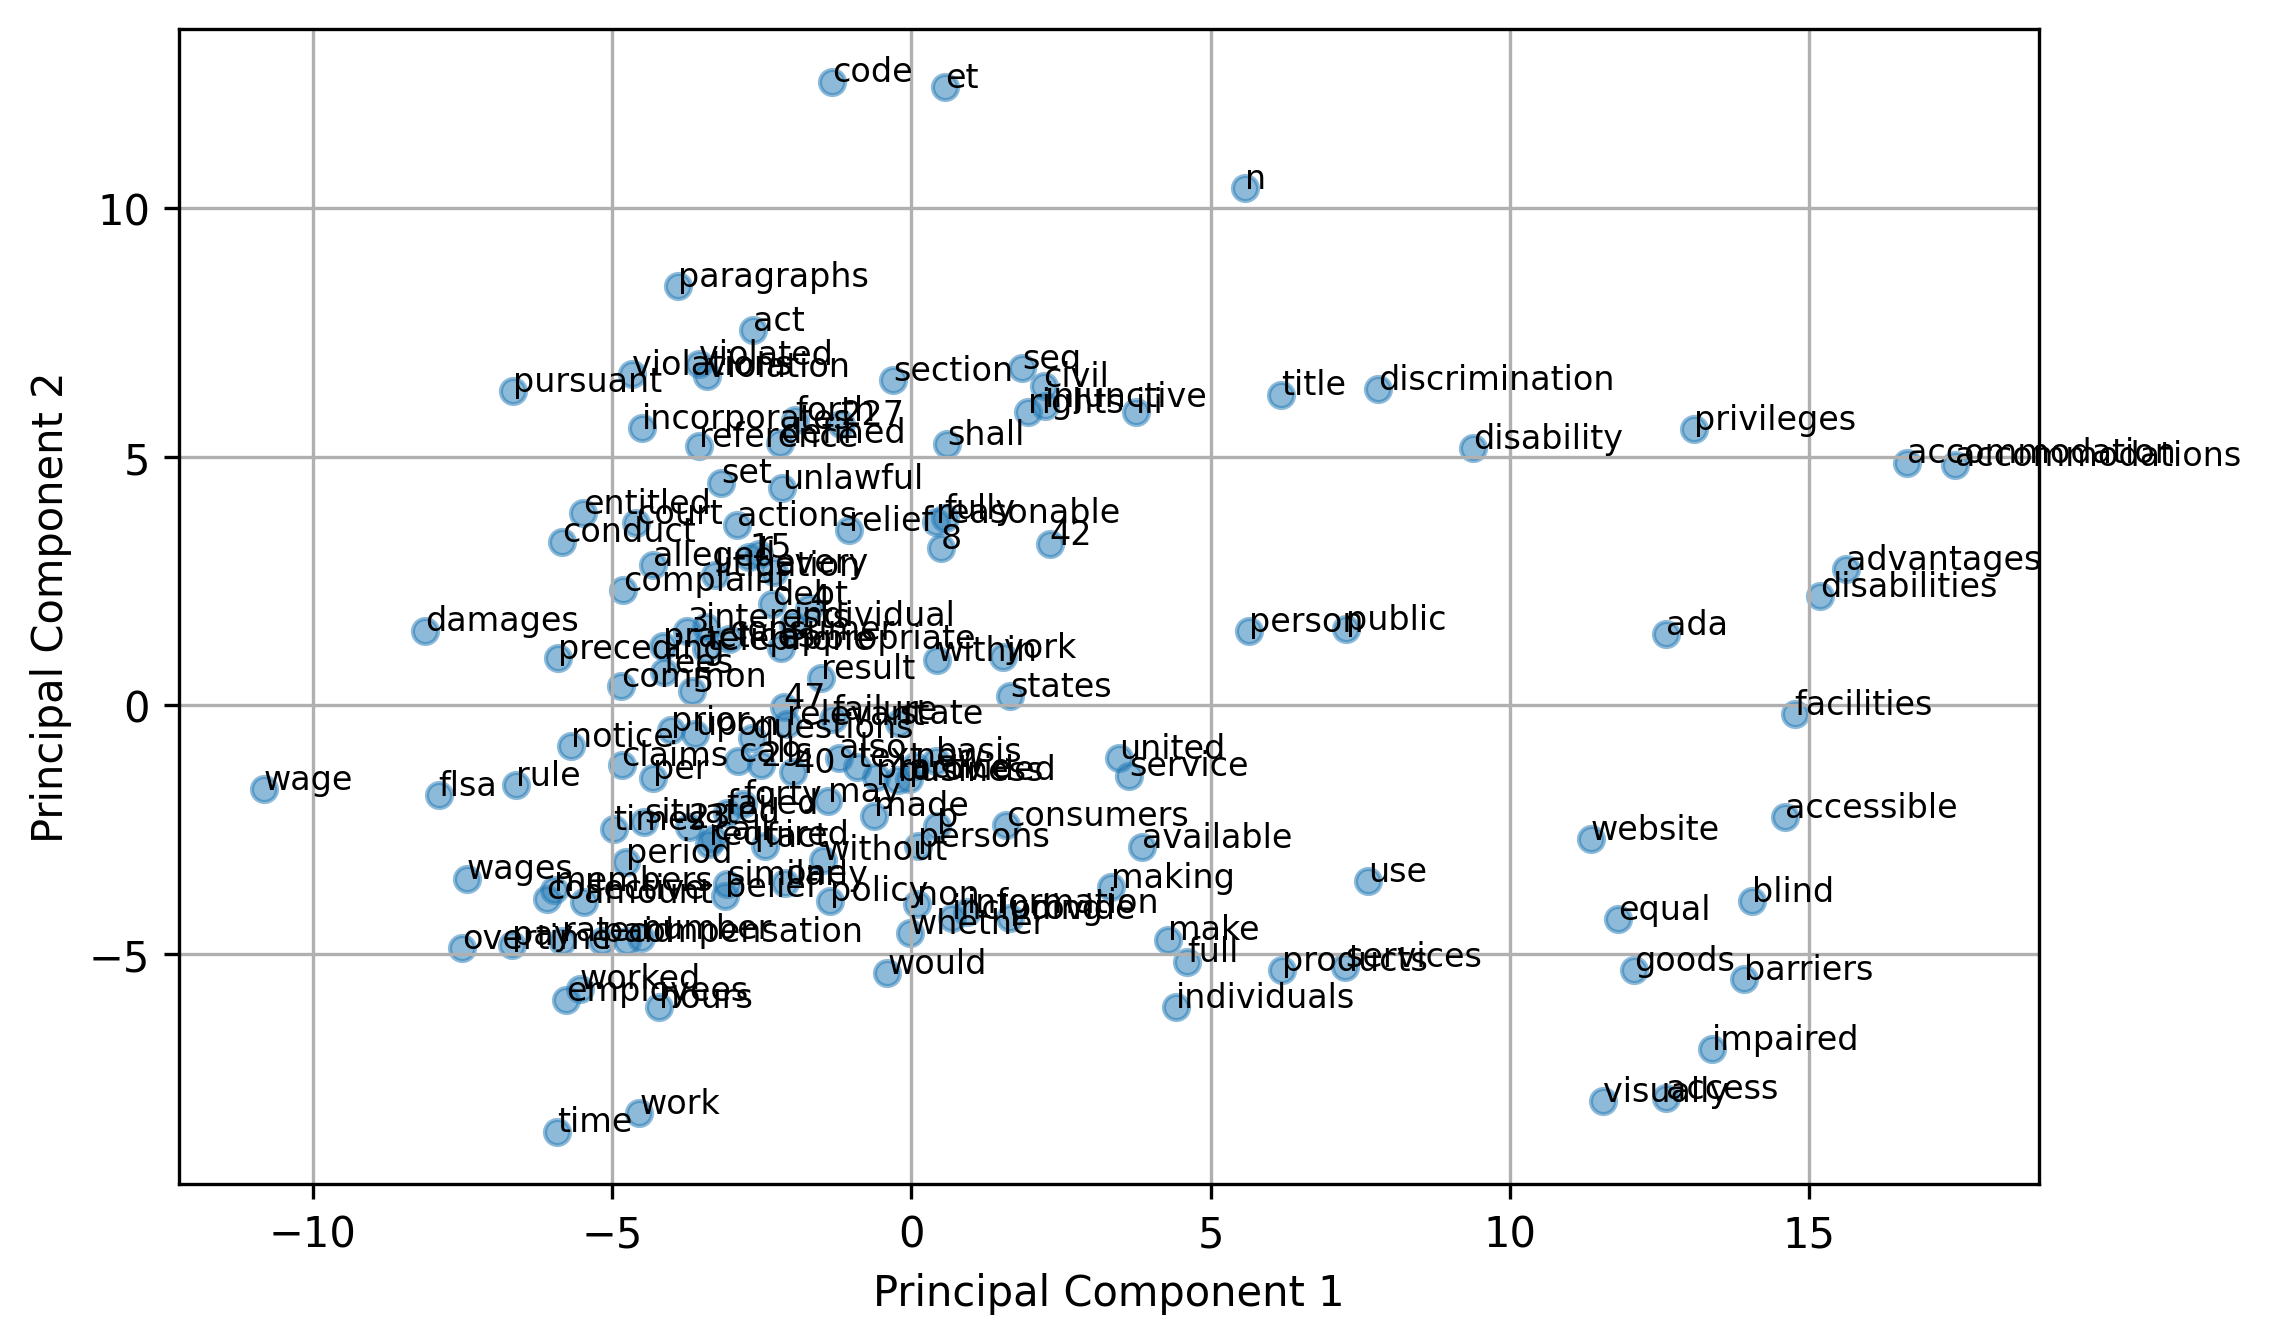

In [24]:
# Visualize word vectors

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(word_vectors[:, 0], word_vectors[:, 1], alpha=0.5)

for i, word in enumerate(words):
    ax.annotate(word, xy=(word_vectors[i, 0], word_vectors[i, 1]), fontsize=8)
    
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.grid(True)
plt.show()

### Document embedding

In [25]:
# Define function to embed a document, given a word embedding model

def embed_document(document, model):
    # Initialize empty string of word vectors
    word_vectors = []
    
    # Get valid words    
    for word in document:
        if word in model.wv.index_to_key:
            word_vectors.append(model.wv[word])
    
    # Return zero vector if list is empty 
    if not word_vectors:
        return np.zeros(model.vector_size)

    # Get document embedding by averaging word vectors
    document_embedding = np.mean(word_vectors, axis=0)
    
    return document_embedding

In [26]:
# Apply embed_document to each document

df['embeddings'] = df['cleaned_facts'].apply(embed_document, model=embeddings)

### Feature extraction

In [31]:
# Create feature matrix

X = np.vstack(df['embeddings'])

In [32]:
# Create target vector mapping

y_map = {'lose': 0, 'win': 1}

In [33]:
# Map target vector

df['verdict'] = df['verdict'].map(y_map)

In [34]:
# Create target vector

y = df['verdict'].values

### Data export

In [36]:
np.save('../data/X.npy', X)
np.save('../data/y.npy', y)